# Disaster Tweets
In this project, we are trying to use deep learning to predict whether a tweet is about real disasters or not. First of all, we would like to understand the data structure of the dataset.

In [67]:
import numpy as np
import pandas as pd

df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
print(df.head(5))
print(df[df['keyword'].notna()].head(5))
print(df[df['location'].notna()].head(5))
print(df.info())
print(df.columns)
print(df['target'].unique())
print(df['keyword'].unique()[:10])

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
    id keyword                       location  \
31  48  ablaze                     Birmingham   
32  49  ablaze  Est. September 2012 - Bristol   
33  50  ablaze                         AFRICA   
34  52  ablaze               Philadelphia, PA   
35  53  ablaze                     London, UK   

                                                 text  target  
31  @bbcmtd Wholesale Markets ablaze http://t.co/l...       1  
32  We always try to bring the heavy. #met

As is shown above, there are five columns in the train dataset that contains 7613 entries. The five columns are respectively id, keyword, location, text and target. There are many possible values for keyword and location, whilst they can be null sometimes. As for the target, it is boolean which can be 1 or 0.

Now we can clean up the data. Recall that the column "id" is useless for our project and that there are NaN values in our dataset, which are to be eliminated.

In [68]:
df=df.drop(columns=['id'])
df.fillna(value='', inplace=False)

,keyword,location,text,target
0,,,Our Deeds are the Reason of this #earthquake M...,1
1,,,Forest fire near La Ronge Sask. Canada,1
2,,,All residents asked to 'shelter in place' are ...,1
3,,,"13,000 people receive #wildfires evacuation or...",1
4,,,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...
7608,,,Two giant cranes holding a bridge collapse int...,1
7609,,,@aria_ahrary @TheTawniest The out of control w...,1
7610,,,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,,,Police investigating after an e-bike collided ...,1


Following the basic data cleaning, we need to perform basic text preprocessing as well. The library used is NLTK in Python. Above all, we must download the libraries and unzip them if the unzipping is not done automatically.

In [69]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [70]:

import os
import zipfile
if not os.path.exists('/usr/share/nltk_data/corpora/wordnet'):
    with zipfile.ZipFile('/usr/share/nltk_data/corpora/wordnet.zip', 'r') as zipRef:
        zipRef.extractall('/usr/share/nltk_data/corpora')

After all libraries are there, we can perform the text processing and tokenization.

A simplified and less robust approach to get rid of puntuations, numbers and other unwanted characters is using regular expression to filter out only the normal alphabetical letters. After that, since cases should not have an impact on the model training, we lower the case of all the letters.

To rule out the impact of conjugation and different forms of the same word, we need to first split the text into words and lemmatize the words one by one, after which we join the lemmatized words by a space, which is our final processed text!

In some cases, we can use the tagger to filter words based on the functions of the words; however, for simplicity, I decided not to use a tagger for this project.

In [71]:

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re


lemmatizer = WordNetLemmatizer()
stopWords = set(stopwords.words('english'))

for i,r in df.iterrows():
    ws=re.sub(r'[^a-zA-Z\s]', '', r['text']).lower().split()
    lws = [lemmatizer.lemmatize(w) for w in ws if not w in stopWords]
    df['processed']=' '.join(lws)

Knowing that machine takes numeric values and do not understand texts, so we must use a tokenizer to convert the processed texts into matrices of numeric values.

My tokenizer limits the most frequent word count for all texts to be 8000, converts the text to lower case (which has been done already) and places a token <OOV> which means "out of vocabulary" for the words not in the top 8000.
    
Last but not least, to maintain a reasonable size of features, we limit the size of input for the deep learning model to be 50 (parameter maxlen). In case that in a text, the produced tokenized matrix has less than 50 elements, some paddings of 0 will be added to maintain the same size.
    
It is possible to use TFI-DF method among many other methods to tokenize processed text, just to mention here.

In [72]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=8000, lower=True, oov_token="<OOV>") 
tokenizer.fit_on_texts(df['processed'])
X=pad_sequences(tokenizer.texts_to_sequences(df['processed']),maxlen=50)

# Alternatively, we can use bag of words, TFIDF and embedding methods

Now that we have a bunch of matrices representing the texts, which is our X, we want to split it into a training set and a validation set. We want to do the same thing for y, which is the label, as well.

In [73]:
from sklearn.model_selection import train_test_split
X_tr, X_v, y_tr, y_v = train_test_split(X, df['target'], test_size=0.2, random_state=42)

In parallel, we want to design our deep learning model. 

To begin with, we must convert the tokenized matrices that are as big as the vocabulary size that I defined, into a trainable layer, which has a reasonable size, which was chosen to be 128. 

In the context of text analysis, previous words should be taken into account to evaluate the impact of a certain word in a text, so we need to use an algorithm involving time sequence, which is why the layer LSTM is there. The first dropout is applied on the input and the second one is applied on the connections between time steps, preventing overfitting.

In order to learn the complex relationships among the texts, a dense layer is added after the LSTM. A dropout layer follows it to prevent overfitting. At the end, recall that we are dealing with a binary classification problem, we must convert the last layer to a single boolean value, which is why a dense layer using sigmoid as the activation function was chosen.

To evaluate the model, we have many optimizers to choose from, among which there is 'adam'. We chose binary cross entropy to be the loss function since the problem is a binary classification problem and we chose the accuracy as the metrics.

Just for information, accuracy can be replaced by 'f1_score' or 'recall'. In addition, 'adam' can be replaced by 'rmsprop' which is also a good optimizer for the problem.

In [74]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model=Sequential(
[
     # 8000 must match the hyper parameters before
    Embedding(input_dim=8000,output_dim=128),
    LSTM(128,dropout=0.2,recurrent_dropout=0.2),
    Dense(128,activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid')
])
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Now we have the model and the data, we can train the model. We set the batch size to be 32 and times of iteration to be 15, and we get the loss and accuracy at the end. If we want, we can also get the learning curve by recuperating the value of model.fit.

In [75]:
model.fit(X_tr, y_tr, batch_size=32, epochs=15, validation_data=(X_v, y_v))
loss, acc = model.evaluate(X_v, y_v)
print(loss,acc)

Epoch 1/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 17s 71ms/step - accuracy: 0.5691 - loss: 0.6864 - val_accuracy: 0.5739 - val_loss: 0.6826
Epoch 2/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - accuracy: 0.5651 - loss: 0.6855 - val_accuracy: 0.5739 - val_loss: 0.6831
Epoch 3/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.5620 - loss: 0.6866 - val_accuracy: 0.5739 - val_loss: 0.6822
Epoch 4/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - accuracy: 0.5622 - loss: 0.6863 - val_accuracy: 0.5739 - val_loss: 0.6822
Epoch 5/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.5738 - loss: 0.6835 - val_accuracy: 0.5739 - val_loss: 0.6826
Epoch 6/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - accuracy: 0.5748 - loss: 0.6826 - val_accuracy: 0.5739 - val_loss: 0.6823
Epoch 7/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.5666 - loss: 0.6851 - val_accuracy: 0.5739 - val_loss: 0.6822
Epoch 8/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - accuracy: 0.5786 - loss: 0.6811 - 

Now that the model works for the design with random hyperparameters, to improve the performance, we would like to perform hyperparameter tuning with the aide of keras_tuner, which allows us to put ranges for the hyperparameters. All the hyperparameters can be specified as ranges, such as all the output dimensions, batch size, optimizer, dropout rate, etc.

In [76]:
from keras_tuner import Hyperband

def buildModel(hp):
    model=Sequential()
    model.add(Embedding(input_dim=8000,output_dim=hp.Int('embeddingDim',64,64*3,step=64)))
    model.add(LSTM(hp.Int('LSTMUnits',64,64*3,step=64)
                   ,dropout=hp.Float('dropout1', 0.4, 0.5, step=0.1)
                   ,recurrent_dropout=hp.Float('dropout2', 0.4, 0.5, step=0.1)))
    model.add(Dense(hp.Int('dense_units', 64, 64*3, step=64),activation='relu'),
        Dropout(hp.Float('dropout3', 0.4, 0.5, step=0.1)))
    model.add(Dense(1,activation='sigmoid'))

    model.compile(optimizer=hp.Choice('optimizer', ['adam', 'rmsprop'])
                  ,loss='binary_crossentropy'
                  ,metrics=['accuracy'])
    return model

tuner=Hyperband(buildModel,objective='val_accuracy',max_epochs=5,factor=3,project_name='Hyperparam Tuning Lab4')
tuner.search(X_tr,y_tr,epochs=5,validation_data=(X_v,y_v),batch_size=32 #hp.Int('batchSize',16,48,step=16)
            )
bestParams=tuner.get_best_hyperparameters(num_trials=1)[0]

print(bestParams.get('embeddingDim'),
      bestParams.get('LSTMUnits'),
      bestParams.get('dropout1'),
      bestParams.get('dropout2'),
      bestParams.get('dropout3'),
      bestParams.get('dense_units'),
      bestParams.get('optimizer')
     )

Reloading Tuner from ./Hyperparam Tuning Lab4/tuner0.json
64 128 0.4 0.4 0.4 192 rmsprop


After the tuning process, we were able to find out the optimal hyperparameters, with which we could train our best model.

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accuracy: 0.5734 - loss: 0.6832 - val_accuracy: 0.5739 - val_loss: 0.6824
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - accuracy: 0.5641 - loss: 0.6857 - val_accuracy: 0.5739 - val_loss: 0.6822
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.5740 - loss: 0.6829 - val_accuracy: 0.5739 - val_loss: 0.6825
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - accuracy: 0.5735 - loss: 0.6831 - val_accuracy: 0.5739 - val_loss: 0.6823
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accuracy: 0.5676 - loss: 0.6848 - val_accuracy: 0.5739 - val_loss: 0.6823
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - accuracy: 0.5583 - loss: 0.6866 - val_accuracy: 0.5739 - val_loss: 0.6824
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accuracy: 0.5661 - loss: 0.6847 - val_accuracy: 0.5739 - val_loss: 0.6822
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accuracy: 0.5767 - loss: 0.6815 - 

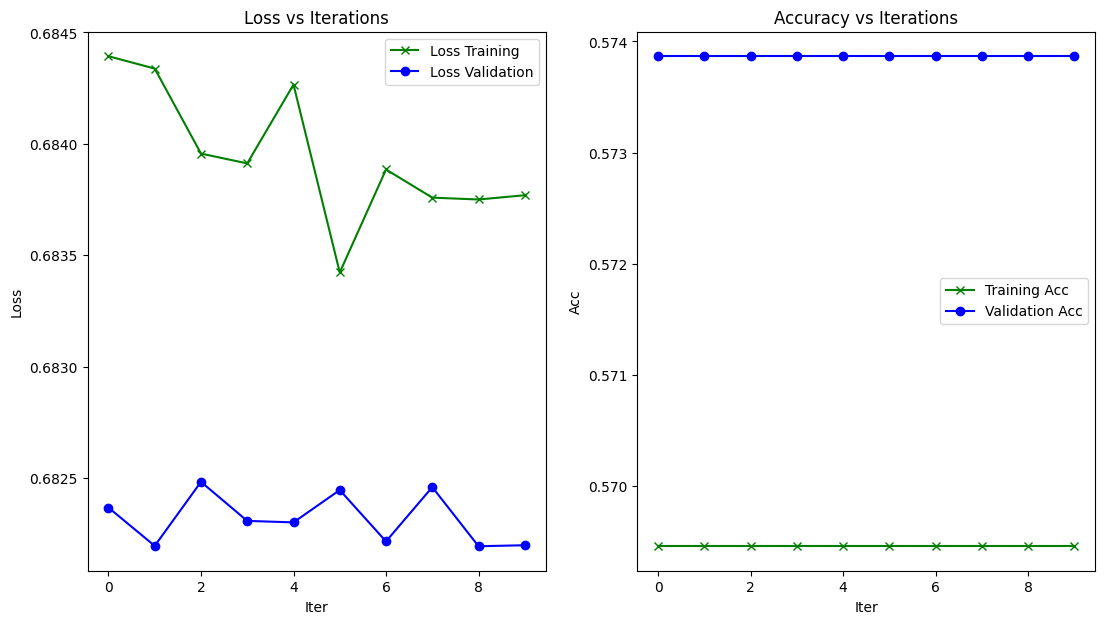

In [77]:
import matplotlib.pyplot as plt
bestModel=tuner.hypermodel.build(bestParams)
hist=model.fit(X_tr, y_tr, batch_size=32, epochs=10, validation_data=(X_v, y_v))
#loss, acc = model.evaluate(X_v, y_v)
#print(loss,acc)

loss_tr=hist.history['loss']
acc_tr = hist.history['accuracy']
loss_v = hist.history['val_loss']
acc_v = hist.history['val_accuracy']

plt.figure(figsize=(13, 7))

plt.subplot(1, 2, 1)
plt.plot(loss_tr, label='Loss Training', color='green',marker='x')
plt.plot(loss_v, label='Loss Validation', color='blue',marker='o')
plt.title('Loss vs Iterations')
plt.xlabel('Iter')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(acc_tr, label='Training Acc', color='green',marker='x')
plt.plot(acc_v, label='Validation Acc', color='blue',marker='o')
plt.title('Accuracy vs Iterations')
plt.xlabel('Iter')
plt.ylabel('Acc')
plt.legend()

plt.show()

As a conclusion, we have obtained the best model which is shown as above.

To improve the performance of the model, we can carry out more detailed hyperparameter tuning. In addition, maybe we can also include more data and maybe even include some columns that we did not look at in the deep learning model.

For the submission.

In [79]:
import numpy as np
import pandas as pd

df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

for i,r in df.iterrows():
    ws=re.sub(r'[^a-zA-Z\s]', '', r['text']).lower().split()
    lws = [lemmatizer.lemmatize(w) for w in ws if not w in stopWords]
    df['processed']=' '.join(lws)
    
tokenizer.fit_on_texts(df['processed'])
X=pad_sequences(tokenizer.texts_to_sequences(df['processed']),maxlen=50)
pred = bestModel.predict(X)

df2=pd.DataFrame({
    'id': df['id'], 
    'target': pred.flatten()
})
df2.to_csv('/kaggle/working/predictions_output.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
